### SI Figure notebook to calculate systematic cell type gene expression differences between MERFISH and scRNAseq

In [3]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import anndata as ad
import scanpy as sc
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [4]:
# Load data
fileDir = '../../../data/SingleCellData/annotated/'

liver_concat = ad.read_h5ad(fileDir + 'scVI_liver_object.h5ad')
kidney_concat = ad.read_h5ad(fileDir + 'scVI_kidney_object.h5ad')
VizgenLiver = ad.read_h5ad(fileDir + 'MERFISH_liver_object.h5ad')
VizgenKidney = ad.read_h5ad(fileDir + 'MERFISH_kidney_object.h5ad')

# Remap cell type labels to coarse groups
liver_relabel_map = {'B cell': 'immune cell',
                    'NK cell': 'immune cell',
                    'periportal endothelial cell': 'periportal endothelial cell',
                    'pericentral endothelial cell': 'pericentral endothelial cell',
                    'other endothelial cell': 'other endothelial cell',
                    'myeloid leukocyte': 'immune cell',
                    'plasmacytoid dendritic cell': 'immune cell',
                    'Kupffer cell': 'Kupffer cell',
                    'hepatic stellate cell': 'hepatic stellate cell',
                    'other hepatocyte': 'other hepatocyte',
                    'periportal hepatocyte': 'periportal hepatocyte',
                    'pericentral hepatocyte': 'pericentral hepatocyte'}
kidney_relabel_map = {'macrophage': 'immune cell',
                     'lymphocyte': 'immune cell',
                     'glomerular capillary endothelial cell': 'endothelial cell',
                     'kidney blood vessel cell': 'endothelial cell',
                     'plasma cell': 'immune cell',
                     'epithelial cell of proximal tubule': 'epithelial cell of proximal tubule',
                     'kidney loop of Henle epithelial cell': 'kidney loop of Henle epithelial cell',
                     'kidney distal convoluted tubule epithelial cell': 'kidney distal convoluted tubule epithelial cell',
                     'kidney collecting duct epithelial cell': 'kidney collecting duct epithelial cell',
                     'pericyte': 'pericyte',
                     'podocyte': 'podocyte',
                     'fibroblast': 'fibroblast'}

liver_concat.obs['predicted_cell_type'] = liver_concat.obs['predicted_cell_type'].map(liver_relabel_map)
kidney_concat.obs['predicted_cell_type'] = kidney_concat.obs['predicted_cell_type'].map(kidney_relabel_map)

# Create abbreviated cell type labels
liver_abbrev_map = {'immune cell': 'IC',
                   'other endothelial cell': 'o-EC',
                   'Kupffer cell': 'KC',
                   'hepatic stellate cell': 'HSC',
                   'other hepatocyte': 'o-hep',
                   'periportal hepatocyte': 'PP-hep',
                   'pericentral hepatocyte': 'PC-hep',
                   'periportal endothelial cell': 'PP-EC',
                   'pericentral endothelial cell': 'PC-EC',
                   'bile duct epithelial cell': 'BD-EC'}
kidney_abbrev_map = {'epithelial cell of proximal tubule':'EC-PT',
                    'immune cell': 'IC',
                    'pericyte':'per',
                    'kidney loop of Henle epithelial cell':'KLH-EC',
                    'kidney collecting duct epithelial cell':'KCD-EC',
                    'kidney distal convoluted tubule epithelial cell':'KDCT-EC',
                    'endothelial cell': 'EC',
                    'podocyte':'pod',
                    'fibroblast':'fib'}

liver_concat.obs['predicted_cell_type_abv'] = liver_concat.obs['predicted_cell_type'].map(liver_abbrev_map)
VizgenLiver.obs['free_annotation_abv'] = VizgenLiver.obs['free_annotation'].map(liver_abbrev_map)
kidney_concat.obs['predicted_cell_type_abv'] = kidney_concat.obs['predicted_cell_type'].map(kidney_abbrev_map)
VizgenKidney.obs['free_annotation_abv'] = VizgenKidney.obs['free_annotation'].map(kidney_abbrev_map)

print('Results loaded.')

Results loaded.


In [5]:
# Calculate cosine similarity between cell types of interest
MERFISH_pod = VizgenKidney[VizgenKidney.obs['free_annotation'] == 'podocyte']
scRNAseq_pod = kidney_concat[(kidney_concat.obs['tech'] == 'scRNA-seq') & 
                             (kidney_concat.obs['predicted_cell_type'] == 'podocyte')]
scRNAseq_endo = kidney_concat[(kidney_concat.obs['tech'] == 'scRNA-seq') & 
                             (kidney_concat.obs['predicted_cell_type'] == 'endothelial cell')]

MERFISH_pphep = VizgenLiver[VizgenLiver.obs['free_annotation'] == 'periportal hepatocyte']
scRNAseq_pphep = liver_concat[(liver_concat.obs['tech'] == 'scRNA-seq') & 
                             (liver_concat.obs['predicted_cell_type'] == 'periportal hepatocyte')]
scRNAseq_pchep = liver_concat[(liver_concat.obs['tech'] == 'scRNA-seq') & 
                             (liver_concat.obs['predicted_cell_type'] == 'pericentral hepatocyte')]

# Use intersection of genes
MERFISH_pod = MERFISH_pod[:, scRNAseq_pod.var.index]
MERFISH_pphep = MERFISH_pphep[:, scRNAseq_pphep.var.index]

# Calculate cosine similarity using all the genes
# We are adding blank columns to make coloring in the plots more easily automated
sim_pod = pd.DataFrame(index=MERFISH_pod.obs.index,
                       columns=['podocyte', 'endothelial cell'])
sim_pod['podocyte'] = cosine_similarity(MERFISH_pod.X, scRNAseq_pod.X).mean(axis=1)
sim_pod['endothelial cell'] = cosine_similarity(MERFISH_pod.X, scRNAseq_endo.X).mean(axis=1)

sim_pphep = pd.DataFrame(index=MERFISH_pphep.obs.index,
                       columns=['periportal hepatocyte', 'pericentral hepatocyte'])
sim_pphep['periportal hepatocyte'] = cosine_similarity(MERFISH_pphep.X, scRNAseq_pphep.X).mean(axis=1)
sim_pphep['pericentral hepatocyte'] = cosine_similarity(MERFISH_pphep.X, scRNAseq_pchep.X).mean(axis=1)

# Calculate again using only marker genes
pod_markers = ['wt1',
               'actn4',
               'synpo',
               'dag1',
               'foxc1',
               'podxl',
               'mme']
pphep_markers = ['cyp2f2',
                 'pck1',
                 'hal',
                 'cdh1']
MERFISH_pod_sub = MERFISH_pod[:, pod_markers]
scRNAseq_pod_sub = scRNAseq_pod[:, pod_markers]
scRNAseq_endo_sub = scRNAseq_endo[:, pod_markers]
MERFISH_pphep_sub = MERFISH_pphep[:, pphep_markers]
scRNAseq_pphep_sub = scRNAseq_pphep[:, pphep_markers]
scRNAseq_pchep_sub = scRNAseq_pchep[:, pphep_markers]

sim_pod_sub = pd.DataFrame(index=MERFISH_pod_sub.obs.index,
                       columns=['podocyte', 'endothelial cell'])
sim_pod_sub['podocyte'] = cosine_similarity(MERFISH_pod_sub.X, scRNAseq_pod_sub.X).mean(axis=1)
sim_pod_sub['endothelial cell'] = cosine_similarity(MERFISH_pod_sub.X, scRNAseq_endo_sub.X).mean(axis=1)

sim_pphep_sub = pd.DataFrame(index=MERFISH_pphep_sub.obs.index,
                       columns=['periportal hepatocyte', 'pericentral hepatocyte'])
sim_pphep_sub['periportal hepatocyte'] = cosine_similarity(MERFISH_pphep_sub.X, scRNAseq_pphep_sub.X).mean(axis=1)
sim_pphep_sub['pericentral hepatocyte'] = cosine_similarity(MERFISH_pphep_sub.X, scRNAseq_pchep_sub.X).mean(axis=1)

In [6]:
# Now do this for all distinct cell types and retain the mean value of each distribution
hsc_markers = ['col1a2',
              'colec11',
              'dcn',
              'sod3',
              'czcl12',
              'prelp',
              'pth1r',
              'ifitm1',
              'tcf21',
              'reln',
              'ecm1',
              'bgn']
kc_markers = ['emr1',
             'clec4f',
             'cd68',
             'irf7',
             'c1qa',
             'c1qc',
             'gm11428',
             'c1qb',
             'tryobp',
             'cfp',
             'fcer1g',
             'lyz2',
             'ctss',
             'aif1',
             'cd5l',
             'c1qb',
             'fcna',
             'fcer1g',
             'folr2',
             'sdc3',
             'vsig4',
             'csf1r',
             'cfp',
             'slc40a1',
             'cd74',
             'ccl6',
             'sfpi1']



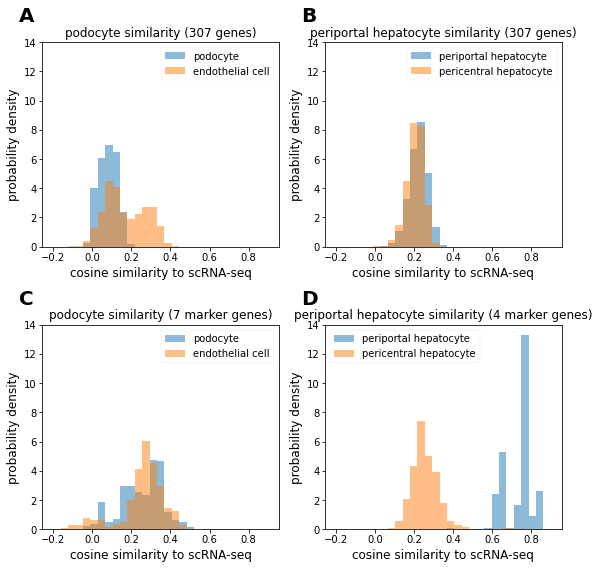

In [7]:
# Plot results

set_plotting_style()

# Plot the whole figure
fig, axes = plt.subplots(2,2, figsize=(8,8))

# Panel A
bins = np.linspace(-0.2, 0.9, 30)
ax = axes[0,0]
sim_pod.plot.hist(ax=ax, alpha=0.5, bins=bins, density=True)
ax.set_ylim(0, 14)
ax.set_xlabel('cosine similarity to scRNA-seq')
ax.set_ylabel('probability density')
ax.set_title('podocyte similarity (307 genes)')

# Panel B
ax = axes[0,1]
sim_pphep.plot.hist(ax=ax, alpha=0.5, bins=bins, density=True)
ax.set_ylim(0, 14)
ax.set_xlabel('cosine similarity to scRNA-seq')
ax.set_ylabel('probability density')
ax.set_title('periportal hepatocyte similarity (307 genes)')

# Panel C
ax = axes[1,0]
sim_pod_sub.plot.hist(ax=ax, alpha=0.5, bins=bins, density=True)
ax.set_ylim(0, 14)
ax.set_xlabel('cosine similarity to scRNA-seq')
ax.set_ylabel('probability density')
ax.set_title('podocyte similarity (7 marker genes)')

# Panel D
ax = axes[1,1]
sim_pphep_sub.plot.hist(ax=ax, alpha=0.5, bins=bins, density=True)
ax.set_ylim(0, 14)
ax.set_xlabel('cosine similarity to scRNA-seq')
ax.set_ylabel('probability density')
ax.set_title('periportal hepatocyte similarity (4 marker genes)')

# Label subpanels
axes_flat = axes.flat
for n, ax in enumerate(axes_flat):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

fig.tight_layout()
plt.show()

In [132]:
# Export figures
fig.savefig('../../figures/SIFig_MERFISH_scRNAseq_similarity.svg', transparent=True)
fig.savefig('../../figures/SIFig_MERFISH_scRNAseq_similarity.png', transparent=True)

print('Figures saved.')

Figures saved.
